# Trabajo práctico 4 

Aritmética de Punto Fijo usando la clase de Python fixedInt.py 

## Ejercicio 1 

Se observa la diferencia entre filtros calculados con punto fijo, para observar el **error cuantización** sobre los coeficientes 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tool._fixedInt import *    # Modulo de punto fijo de Fulgor 3
from tool.DSPtools import * 

### 1) Creamos tres filtros con diferentes rolloff.
 
 Utilizamos la función definida para creal el filtro de *raised cosine*

In [3]:
def rcosine(beta, Tbaud, oversampling, Nbauds, Norm):
    """ Respuesta al impulso del pulso de caida cosenoidal """
    t_vect = np.arange(-0.5*Nbauds*Tbaud, 0.5*Nbauds*Tbaud, 
                       float(Tbaud)/oversampling)

    y_vect = []
    for t in t_vect:
        y_vect.append(np.sinc(t/Tbaud)*(np.cos(np.pi*beta*t/Tbaud)/
                                        (1-(4.0*beta*beta*t*t/
                                            (Tbaud*Tbaud)))))

    y_vect = np.array(y_vect)

    if(Norm):
        return (t_vect, y_vect/np.sqrt(np.sum(y_vect**2)))
        #return (t_vect, y_vect/y_vect.sum())
    else:
        return (t_vect,y_vect)

Definimos los parametros del filtro 

* Baud Rate 
* Oversampling  
* Rolloff = $\beta$ 
* Frecuencia de muestreo fs 
* Separacion entre simbolos = T (cada cruce por cero del filtro) 


In [4]:
BR = 1e9;                   # Baud Rate 
NB = 16;                    # Numero de simbolos
N = 8;                     # Tasa de sobremuestreo
Beta = [0.0, 0.5, 1.0]      # Rolloff 
fs = N*BR                   # Frecuencia de muestreo 
T = 1/BR                    # Periodo de Baud Rate (Separacion entre symbolos)
Ts = 1/fs                   # Periodo de muestreo (=T/N)


Calculamos los 3 filtros con diferente exceso de ancho de banda y

### 2) Graficamos sus coeficientes (respuesta al impulso por definicion) en el tiempo 

Text(0, 0.5, 'Magnitud')

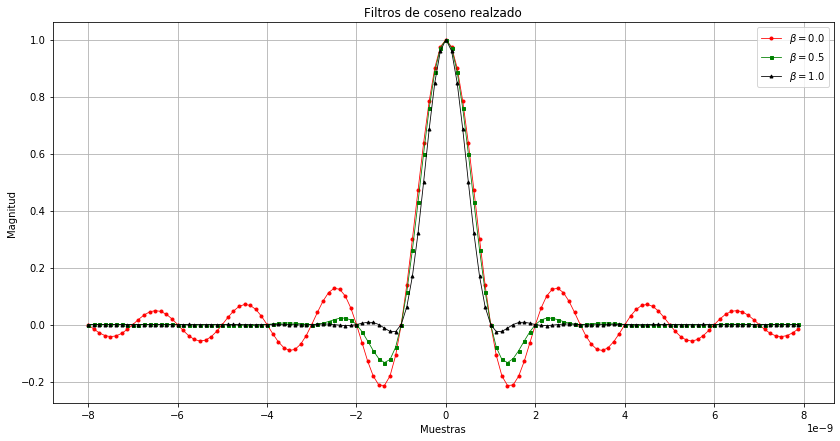

In [24]:
(t,h0) = rcosine(Beta[0], T,N,NB,Norm=False)
(t,h1) = rcosine(Beta[1], T,N,NB,Norm=False)
(t,h2) = rcosine(Beta[2], T,N,NB,Norm=False)

### Generacion de las graficas
plt.figure(figsize=[14,7])
plt.plot(t,h0,'ro-',linewidth=.80,label=r'$\beta=0.0$',markersize=3)
plt.plot(t,h1,'gs-',linewidth=.80,label=r'$\beta=0.5$',markersize=3)
plt.plot(t,h2,'k^-',linewidth=.80,label=r'$\beta=1.0$',markersize=3)
plt.legend()
plt.grid(True)
#plt.xlim(0,len(rc0)-1)
plt.title("Filtros de coseno realzado")
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

* Graficamos la respuesta en frecuencia. 

Esto se podria realizar calculando la fft() de los coeficientes de los filtros rc, tomando el módulo y convirtiéndolo a dB para luego graficar el módulo de la respuesta en frecuencia. Sin embargo se utiliza la función resp_frecuencia() ya disponible en el módulo otorgado por el profesor. 

In [25]:
### Calculo respuesta en frec para los tres pulsos
NFTT = 1024; 
[H0,A0,F0] = resp_freq(h0, Ts, NFTT)
[H1,A1,F1] = resp_freq(h1, Ts, NFTT)
[H2,A2,F2] = resp_freq(h2, Ts, NFTT)

Graficamos las respuestas en frecuencia 

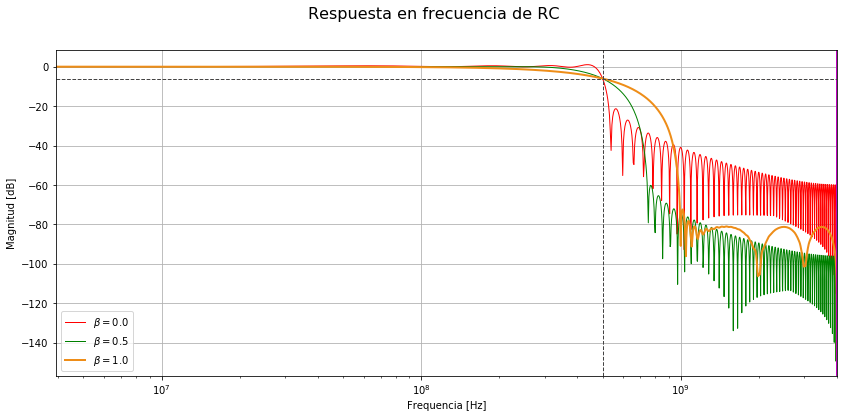

In [26]:
### Generacion de los graficos
### Paso a dB y normalizo para que en f=0 tengan ganancia = 0dB. Para que fc coincida con -6dB. 
H0_dB = 20*np.log10(H0)- 20*np.log10(H0[0])
H1_dB = 20*np.log10(H1)- 20*np.log10(H1[0])
H2_dB = 20*np.log10(H2)- 20*np.log10(H2[0])

fig=plt.figure(figsize=[14,6])
fig.suptitle('Respuesta en frecuencia de RC', fontsize=16)
plt.semilogx(F0,H0_dB ,'r', lw=1.0, label=r'$\beta=0.0$')
plt.semilogx(F1, H1_dB,'g', lw=1.0, label=r'$\beta=0.5$')
plt.semilogx(F2, H2_dB,color='#ee8d18', lw=2.0, label=r'$\beta=1.0$')


plt.axvline(x=(1./Ts)/2.,color='m',linewidth=2.0)
plt.axvline(x=(1./T)/2.,color='#454444',linewidth=1,linestyle="--")              #Frecuencia de corte 
plt.axhline(y=20*np.log10(0.5),color='#454444',linewidth=1,linestyle="--")       #-6d: Modulo a frecuencia de corte  
plt.legend(loc=3)
plt.grid(True)
plt.xlim(F2[1],F2[len(F2)-1])
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.show()

Se puede observar que los 3 filtros raised cosine calculados tienen el **mismo ancho de banda**, es decir su punto de -6dB pasa por la misma frecuencia. El ancho de banda BW = Baud Rate. 
Sin embargo, a mayor rollof **mayor es el ancho de banda de ocupación** en el canal

### 3) Graficamos los simbolos a transimitir filtrados con estos filtros obtenidos anteriormente, realizando la convolucion 

* Generamos símbolos en cuadratura para transmitir QAM4 


In [27]:
Nsymb=1000
symbolsI = 2*(np.random.uniform(-1,1,Nsymb)>0.0)-1;
symbolsQ = 2*(np.random.uniform(-1,1,Nsymb)>0.0)-1;
symbI = np.zeros(N*Nsymb) 
symbQ = np.zeros(N*Nsymb) 

* Agregamos N-1 muestras entre cada símbolos (upsample). 

In [28]:
#Vector de símbolos con N-1 muestras entre estos, debido al Oversamplig. 
symbI[1:len(symbI):int(N)]=symbolsI        
symbQ[1:len(symbQ):int(N)]=symbolsQ

 * Graficamos los símbolos transmitidos 

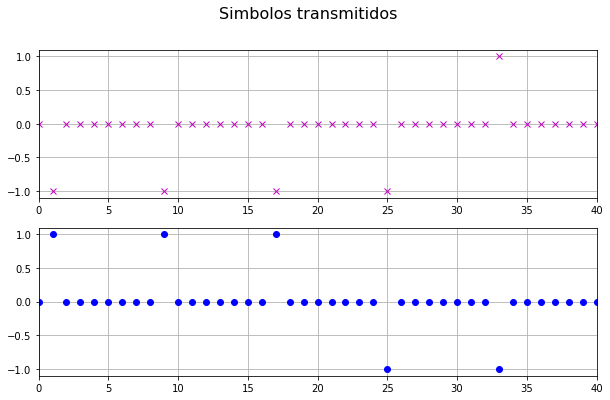

In [29]:
fig=plt.figure(figsize=[10,6])
fig.suptitle('Simbolos transmitidos', fontsize=16)
plt.subplot(2,1,1)
plt.plot(symbI,'xm')
plt.xlim(0,40)
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(symbQ,'ob')
plt.xlim(0,40)
plt.grid(True)
plt.show()

* Realizamos la convolución de los símbolos transmitidos con los tres filtros h(t) de RC 

In [30]:
symb_out0I = np.convolve(h0,symbI,'same')
symb_out0Q = np.convolve(h0,symbQ,'same')

symb_out1I = np.convolve(h1,symbI,'same') 
symb_out1Q = np.convolve(h1,symbQ,'same')

symb_out2I = np.convolve(h2,symbI,'same')
symb_out2Q = np.convolve(h2,symbQ,'same')

* Graficamos las 3 señales s_Q(t) e s_I(t) obtenidas 

Text(0, 0.5, 'Magnitud')

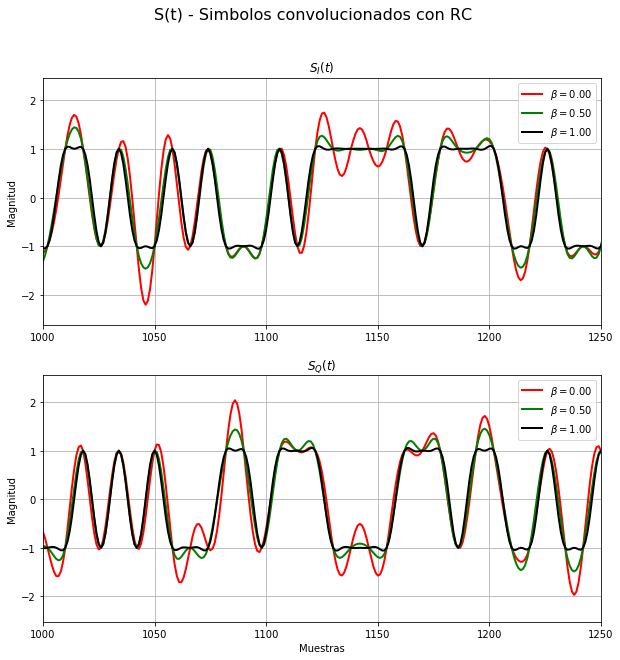

In [31]:
fig=plt.figure(figsize=[10,10])
fig.suptitle('S(t) - Simbolos convolucionados con RC', fontsize=16)

sp1= plt.subplot(2,1,1)
sp1.set_title("$S_I(t)$")
plt.plot(symb_out0I,'r-',linewidth=2.0,label=r'$\beta=%2.2f$'%Beta[0])
plt.plot(symb_out1I,'g-',linewidth=2.0,label=r'$\beta=%2.2f$'%Beta[1])
plt.plot(symb_out2I,'k-',linewidth=2.0,label=r'$\beta=%2.2f$'%Beta[2])
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()

plt.ylabel('Magnitud')

sp2 = plt.subplot(2,1,2)
sp2.set_title("$S_Q(t)$")
plt.plot(symb_out0Q,'r-',linewidth=2.0,label=r'$\beta=%2.2f$'%Beta[0])
plt.plot(symb_out1Q,'g-',linewidth=2.0,label=r'$\beta=%2.2f$'%Beta[1])
plt.plot(symb_out2Q,'k-',linewidth=2.0,label=r'$\beta=%2.2f$'%Beta[2])
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

Se puede observar como a  mayor rolloff la señal posee menos sobrepicos, que pueden llegar a ocasionar problemas en la electrónica si superan cierto umbral de los transistores. 

* Graficamos las constelaciones de los símbolos para los 3 tipos de filtros RC. Como no se agrego ruido de ningún tipo y todos los filtros utilizados son pulsos de Nyquist, las constelaciones son iguales en los 3 casos y se observarán los 4 símbolos exactos. 

Mediantes se pruebas se encontró que la fase es 6. 


Text(0, 0.5, 'Imag')

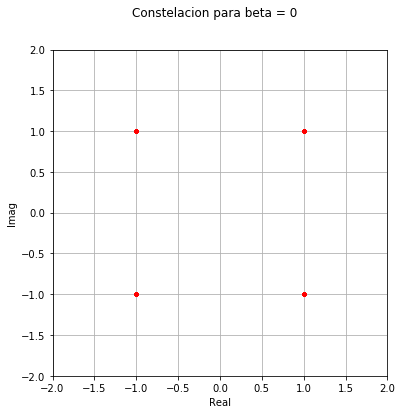

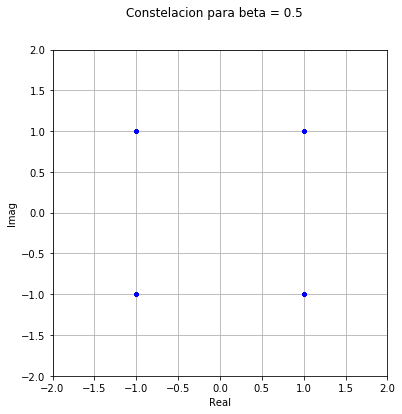

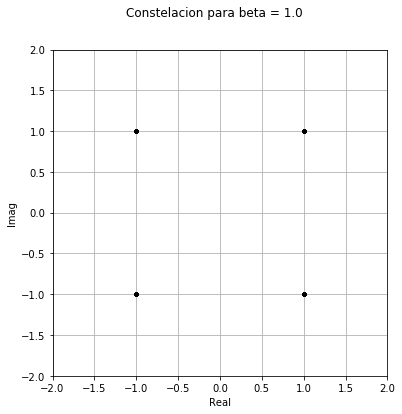

In [32]:
To = 6
fig=plt.figure(figsize=[6,6])
fig.suptitle("Constelacion para beta = 0")
plt.plot(symb_out0I[100+To:len(symb_out0I)-(100-To):int(N)],
         symb_out0Q[100+To:len(symb_out0Q)-(100-To):int(N)],
             '.r',lw=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')

fig=plt.figure(figsize=[6,6])
fig.suptitle("Constelacion para beta = 0.5")
plt.plot(symb_out1I[100+To:len(symb_out1I)-(100-To):int(N)],
         symb_out1Q[100+To:len(symb_out1Q)-(100-To):int(N)],
             '.b',lw=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')


fig=plt.figure(figsize=[6,6])
fig.suptitle("Constelacion para beta = 1.0")
plt.plot(symb_out2I[100+To:len(symb_out2I)-(100-To):int(N)],
         symb_out2Q[100+To:len(symb_out2Q)-(100-To):int(N)],
             '.k',lw=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')

### 4) Cuantizaciones sobre los filtros. 

* Aplicamos la cuantización S(8,7) con truncado sobre los coeficientes de los 3 filtros. 

Para esto utilizamos la función ya definida para crear arreglos de la clase FixedPoint. 

In [33]:
#arrayObjetos = arrayFixedInt(intWidth, fractWidth, N, signedMode='S', roundMode='trunc', saturateMode='saturate')
h0FpS8_7_t = arrayFixedInt(8,7, h0,'S', roundMode='trunc', saturateMode='saturate')
h1FpS8_7_t = arrayFixedInt(8,7, h1,'S', roundMode='trunc', saturateMode='saturate')
h2FpS8_7_t  = arrayFixedInt(8,7, h2,'S', roundMode='trunc', saturateMode='saturate')

* S(8,7) con redondeo 

In [34]:
h0FpS8_7_r = arrayFixedInt(8,7, h0,'S', roundMode='round', saturateMode='saturate')
h1FpS8_7_r = arrayFixedInt(8,7, h1,'S', roundMode='round', saturateMode='saturate')
h2FpS8_7_r  = arrayFixedInt(8,7, h2,'S', roundMode='round', saturateMode='saturate')

* S(3,2) con truncado y redondeo 

In [35]:
h0FpS3_2_t = arrayFixedInt(3,2, h0,'S', roundMode='trunc', saturateMode='saturate')
h1FpS3_2_t = arrayFixedInt(3,2, h1,'S', roundMode='trunc', saturateMode='saturate')
h2FpS3_2_t  = arrayFixedInt(3,2, h1,'S', roundMode='trunc', saturateMode='saturate')

h0FpS3_2_r = arrayFixedInt(3,2, h0,'S', roundMode='round', saturateMode='saturate')
h1FpS3_2_r = arrayFixedInt(3,2, h1,'S', roundMode='round', saturateMode='saturate')
h2FpS3_2_r  = arrayFixedInt(3,2, h2,'S', roundMode='round', saturateMode='saturate')

* S(6,4) con truncado y redondeo 

In [36]:
h0FpS6_4_t = arrayFixedInt(6,4, h0,'S', roundMode='trunc', saturateMode='saturate')
h1FpS6_4_t = arrayFixedInt(6,4, h1,'S', roundMode='trunc', saturateMode='saturate')
h2FpS6_4_t  = arrayFixedInt(6,4, h2,'S', roundMode='trunc', saturateMode='saturate')

h0FpS6_4_r = arrayFixedInt(6,4, h0,'S', roundMode='round', saturateMode='saturate')
h1FpS6_4_r = arrayFixedInt(6,4, h1,'S', roundMode='round', saturateMode='saturate')
h2FpS6_4_r  = arrayFixedInt(6,4, h2,'S', roundMode='round', saturateMode='saturate')

* Realizamos las gráficas anteriores para compara 

    #### Respuesta en frecuencia 

In [37]:
#Funcion para convertir el arreglo de objetos Fixed Point a float para poder hacer las operaciones necesarias
#como fft o conv()
def FixedPoint2float(ArrayFp): 
    value = []
    for i in range(len(ArrayFp)): 
        value.append(ArrayFp[i].fValue)
    return value 

In [153]:
#Compruebo
#MM = FixedPoint2float(h0FpS8_7_t)
#print(MM[50], h0FpS8_7_t[50].fValue, h0[50])

In [38]:
#Grafico de a 3                                                                               
def CompGraficos(h0,h1,h2,NFFT,Title):                                           
    NFTT = 1024;                                                                
    [H0,A0,F0] = resp_freq(FixedPoint2float(h0), Ts, NFTT)                         
    [H1,A1,F1] = resp_freq(FixedPoint2float(h1), Ts, NFTT)                         
    [H2,A2,F2] = resp_freq(FixedPoint2float(h2), Ts, NFTT)                         
    ### Generacion de los graficos                                                 
    ### Paso a dB y normalizo para que en f=0 tengan ganancia = 0dB. Para que fc coincida con -6dB. 
    H0_dB = 20*np.log10(H0)- 20*np.log10(H0[0])                                    
    H1_dB = 20*np.log10(H1)- 20*np.log10(H1[0])                                    
    H2_dB = 20*np.log10(H2)- 20*np.log10(H2[0])                                    
                                                                                   
    fig=plt.figure(figsize=[14,6])                                                 
    fig.suptitle(Title, fontsize=16)                                               
    plt.semilogx(F0,H0_dB ,'r', lw=2.0, label=r'$\beta=0.0$')                      
    plt.semilogx(F1, H1_dB,'g', lw=2.0, label=r'$\beta=0.5$')                      
    plt.semilogx(F2, H2_dB,color='#ee8d18', lw=2.0, label=r'$\beta=1.0$')          
                                                                                   
                                                                                   
    plt.axvline(x=(1./Ts)/2.,color='m',linewidth=2.0)                              
    plt.axvline(x=(1./T)/2.,color='#454444',linewidth=1,linestyle="--")              #Frecuencia de corte 
    plt.axhline(y=20*np.log10(0.5),color='#454444',linewidth=1,linestyle="--")       #-6d: Modulo a frecuencia de corte  
    plt.legend(loc=3)                                                              
    plt.grid(True)                                                                 
    plt.xlim(F2[1],F2[len(F2)-1])                                                  
    plt.xlabel('Frequencia [Hz]')                                                  
    plt.ylabel('Magnitud [dB]')                                                    
    plt.show()    

* S(8,7) truncado y redondeado

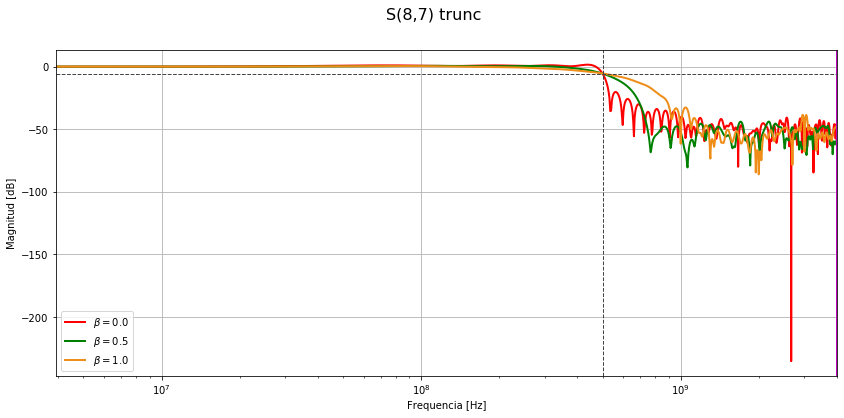

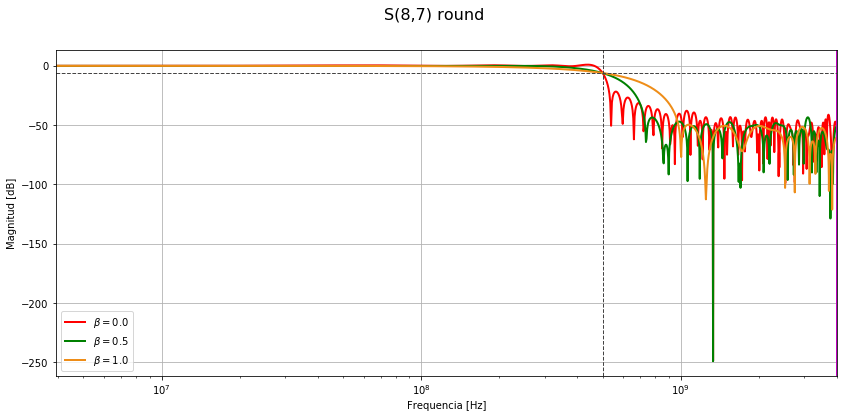

In [39]:
NFFT = 1024; 
CompGraficos(h0FpS8_7_t,h1FpS8_7_t,h2FpS8_7_t,NFFT,"S(8,7) trunc") #Truncados 
CompGraficos(h0FpS8_7_r,h1FpS8_7_r,h2FpS8_7_r,NFFT,"S(8,7) round") #Redondeados 

* S(3,2)

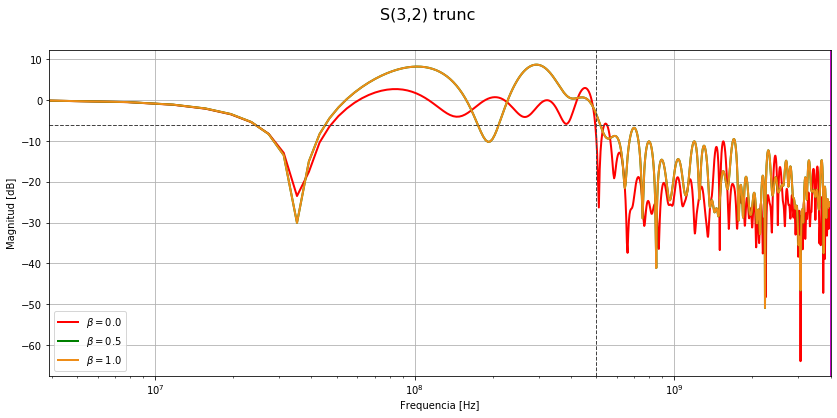

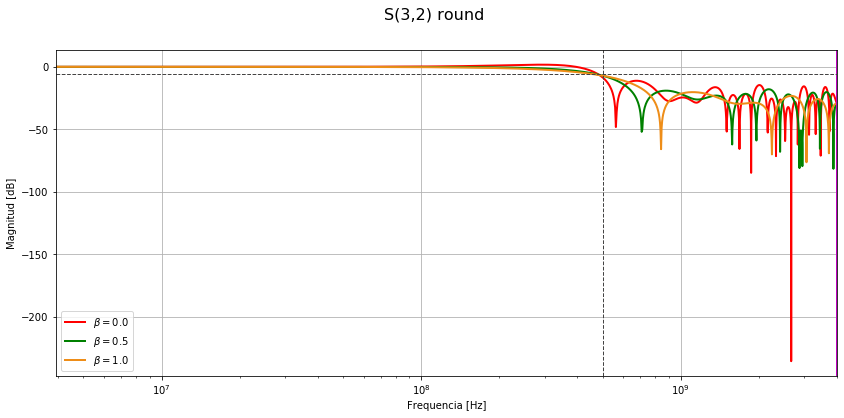

In [40]:
CompGraficos(h0FpS3_2_t,h1FpS3_2_t,h2FpS3_2_t,NFFT,"S(3,2) trunc") #Truncados 
CompGraficos(h0FpS3_2_r,h1FpS3_2_r,h2FpS3_2_r,NFFT,"S(3,2) round") #Redondeados 

* S(6,4) 

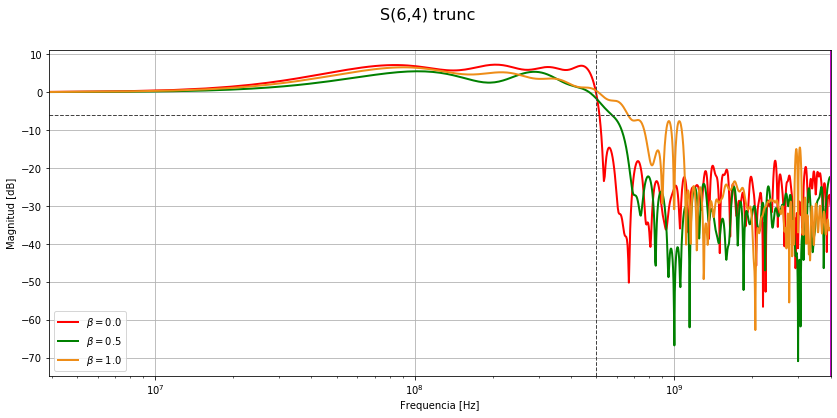

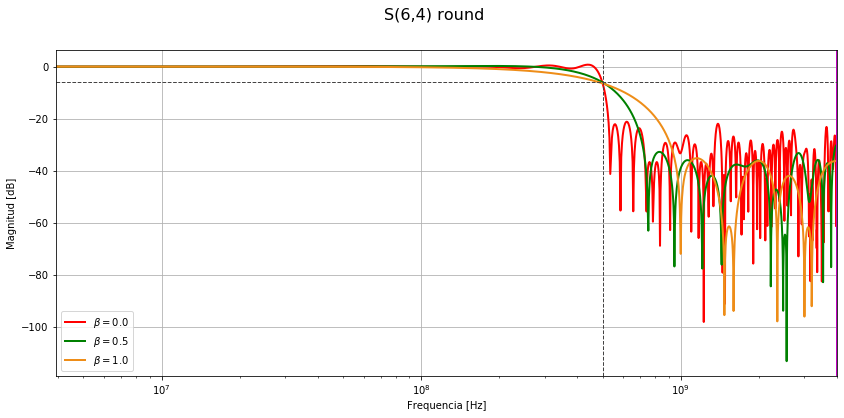

In [41]:
CompGraficos(h0FpS6_4_t,h1FpS6_4_t,h2FpS6_4_t,NFFT,"S(6,4) trunc") #Truncados 
CompGraficos(h0FpS6_4_r,h1FpS6_4_r,h2FpS6_4_r,NFFT,"S(6,4) round") #Redondeados 

#### Convolucion con los simbolos 

Solo graficamos lo símbolos inphase, para que no sea confusa la comparación. 

In [42]:
def GrafConvComp(h0,h1,h2,Title):                                               
    symb_out0I = np.convolve(FixedPoint2float(h0),symbI,'same')                                   
    symb_out1I = np.convolve(FixedPoint2float(h1),symbI,'same')                                   
    symb_out2I = np.convolve(FixedPoint2float(h2),symbI,'same')                                   
                                                                                
    fig=plt.figure(figsize=[10,10])                                             
    fig.suptitle(Title, fontsize=16)                                            
                                                                                
    sp1= plt.subplot(2,1,1)                                                     
    sp1.set_title("$S_I(t)$")                                                   
    plt.plot(symb_out0I,'r-',linewidth=1.0,label=r'$\beta=%2.2f$'%Beta[0])      
    plt.plot(symb_out1I,'g-',linewidth=1.0,label=r'$\beta=%2.2f$'%Beta[1])      
    plt.plot(symb_out2I,'k-',linewidth=1.0,label=r'$\beta=%2.2f$'%Beta[2])      
    plt.xlim(1000,1250)                                                         
    plt.grid(True)                                                              
    plt.legend()                                                                
    plt.xlabel('Muestras')                                                      
    plt.ylabel('Magnitud')                                                                                           

* S(8,7)

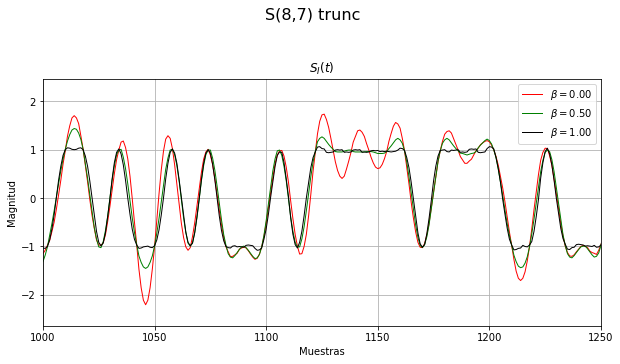

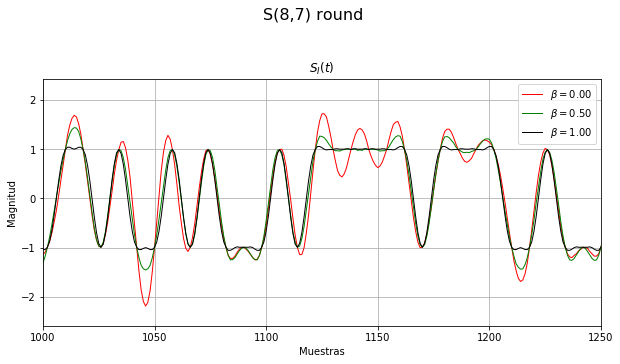

In [43]:
GrafConvComp(h0FpS8_7_t,h1FpS8_7_t,h2FpS8_7_t,"S(8,7) trunc") #Truncados 
GrafConvComp(h0FpS8_7_r,h1FpS8_7_r,h2FpS8_7_r,"S(8,7) round") #Redondeados

* S(6,4)

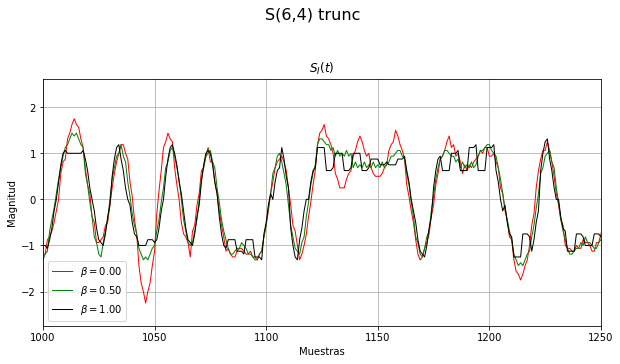

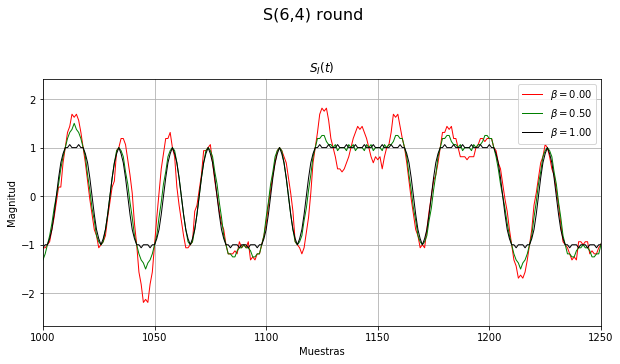

In [44]:
GrafConvComp(h0FpS6_4_t,h1FpS6_4_t,h2FpS6_4_t,"S(6,4) trunc") #Truncados 
GrafConvComp(h0FpS6_4_r,h1FpS6_4_r,h2FpS6_4_r,"S(6,4) round") #Redondeados 

* S(3,2)

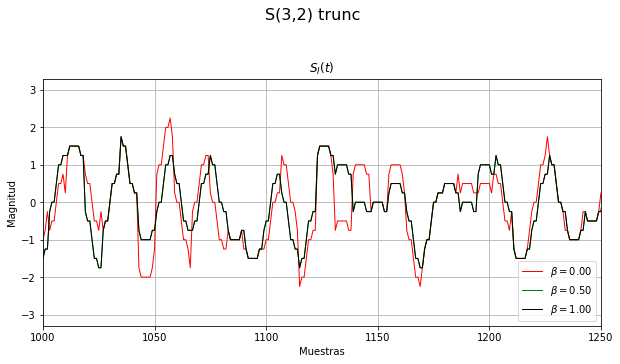

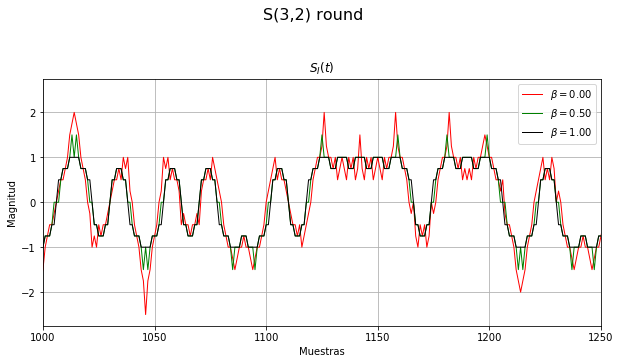

In [45]:
GrafConvComp(h0FpS3_2_t,h1FpS3_2_t,h2FpS3_2_t,"S(3,2) trunc") #Truncados 
GrafConvComp(h0FpS3_2_r,h1FpS3_2_r,h2FpS3_2_r,"S(3,2) round") #Redondeados 

#### Constelaciones

In [46]:
def GrafCompConst(h0,h1,h2,To,Title):                                          
                                                                                
    symb_out0I = np.convolve(FixedPoint2float(h0),symbI,'same')                 
    symb_out1I = np.convolve(FixedPoint2float(h1),symbI,'same')                 
    symb_out2I = np.convolve(FixedPoint2float(h2),symbI,'same')                 
    
    fig = plt.figure(figsize=[14,6])
                                
    fig.suptitle(Title) 
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
        
        
    ax1 = plt.subplot(1,3,1)
    ax2 = plt.subplot(1,3,2)  
    ax3 = plt.subplot(1,3,3)  
            
    ax1.plot(symb_out0I[100+To:len(symb_out0I)-(100-To):int(N)],                
        symb_out0Q[100+To:len(symb_out0Q)-(100-To):int(N)],                     
        '.r',lw=2.0)                                                             
                                                      
    ax1.set_title("beta = 0")                                                   
    ax1.grid(True) 
    ax1.set(xlabel='Real', ylabel='Imag')
                                                         
                       
                                                        
    ax2.plot(symb_out1I[100+To:len(symb_out1I)-(100-To):int(N)],                
             symb_out1Q[100+To:len(symb_out1Q)-(100-To):int(N)],                
                 '.b',lw=2.0)                                                    
                                                         
    ax2.set_title("beta = 0.5")                                                   
    ax2.grid(True)  
    ax2.set(xlabel='Real')
                               
                                                                      
    ax3.plot(symb_out2I[100+To:len(symb_out2I)-(100-To):int(N)],                
             symb_out2Q[100+To:len(symb_out2Q)-(100-To):int(N)],                
                 '.k',lw=2.0)                                                    
                                                   
    ax3.set_title("beta = 1")                                                   
    ax3.grid(True)
    ax3.set(xlabel='Real')

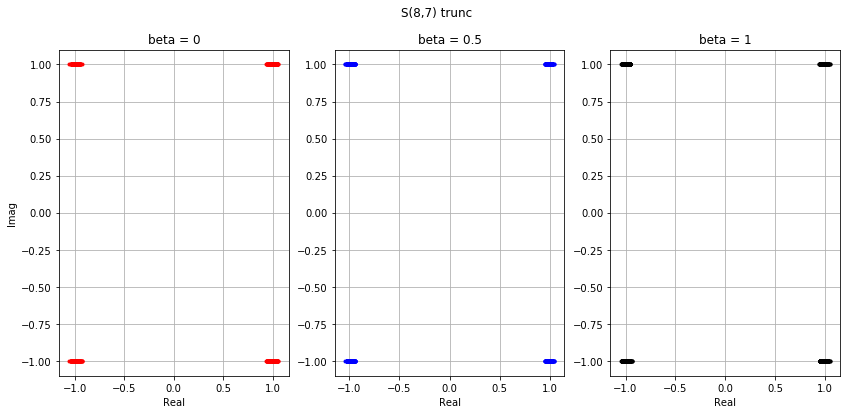

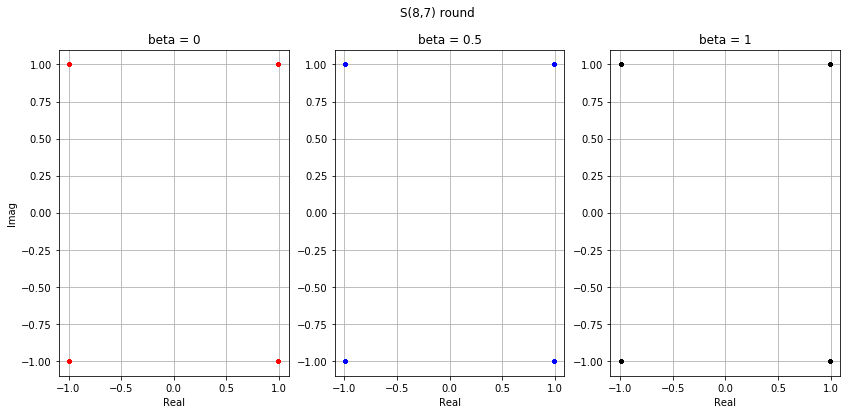

In [47]:
GrafCompConst(h0FpS8_7_t,h1FpS8_7_t,h2FpS8_7_t,6,"S(8,7) trunc") #Truncados 
GrafCompConst(h0FpS8_7_r,h1FpS8_7_r,h2FpS8_7_r,6,"S(8,7) round") #Redondeados

* S(6,4) 

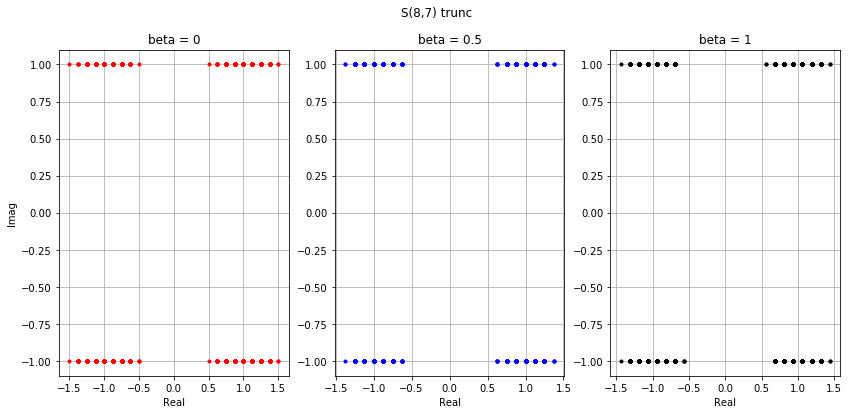

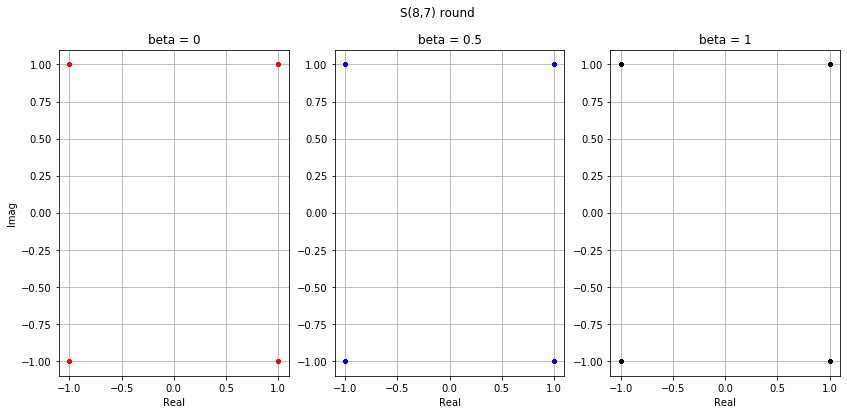

In [48]:
GrafCompConst(h0FpS6_4_t,h1FpS6_4_t,h2FpS6_4_t,6,"S(8,7) trunc") #Truncados 
GrafCompConst(h0FpS6_4_r,h1FpS6_4_r,h2FpS6_4_r,6,"S(8,7) round") #Redondeados

* S(3,2) 

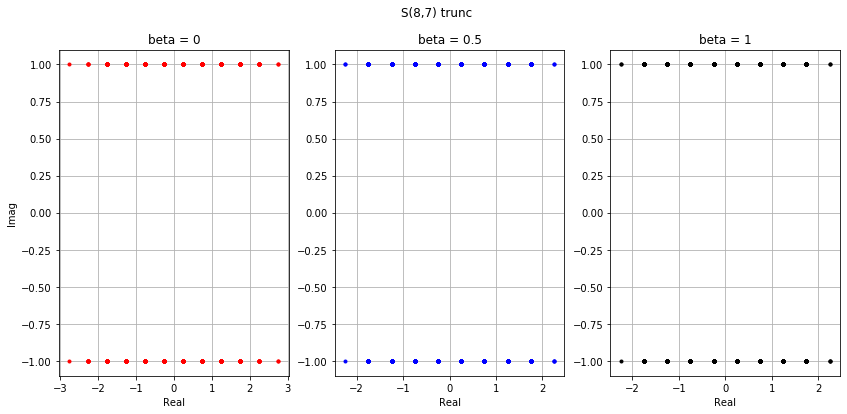

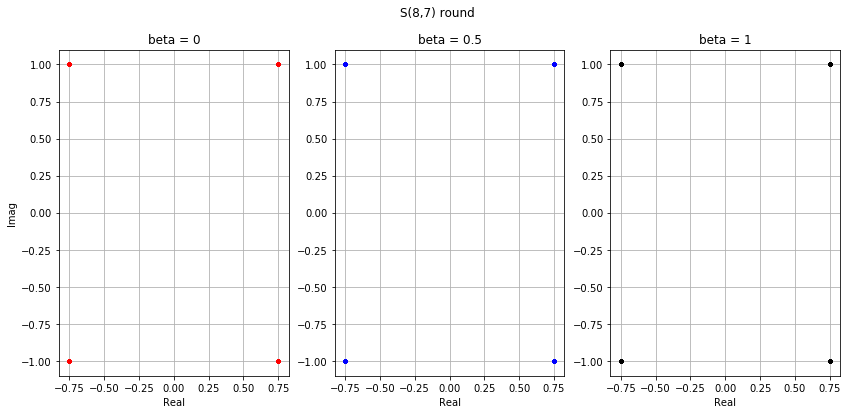

In [49]:
GrafCompConst(h0FpS3_2_t,h1FpS3_2_t,h2FpS3_2_t,6,"S(8,7) trunc") #Truncados 
GrafCompConst(h0FpS3_2_r,h1FpS3_2_r,h2FpS3_2_r,6,"S(8,7) round") #Redondeados

#### Cálculo de la SNR con ruido de cuantización

Resto los coeficientes cuantizados de los no contizuados para obtener el ruido. Eso lo paso a dB y la potencia del ruido. 
